# Chapter 08 - PCA and Clustering

The following exercises, code, and explanations are adapted from An Introduction to Statistical Learning with Applications in Python (ISLP) (James, Witten, Hastie, Tibshirani, and Taylor 2023).

Make sure the following packages are installed prior to running code in this notebook:
- `numpy`
- `pandas`
- `matplotlib`
- `sklearn`
- `scipy`
- `ISLP`
- `seaborn`

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from scipy.optimize import linear_sum_assignment
from ISLP import confusion_table
from ISLP.cluster import compute_linkage

We will also need the following function from the [sklearn website](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html) which is used for plotting dendrograms in the following exercise. 

In [2]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Exercise: `Country` dataset

This exercise uses the `Countries` data set, which contains information on 167 countries. It contains ten variables:
- country: Name of the country
- child_mort: Death of children under 5 years of age per 1000 live births
- exports: Exports of goods and services per capita. Given as %age of the GDP per capita
- health: Total health spending per capita. Given as %age of GDP per capita
- imports: Imports of goods and services per capita. Given as %age of the GDP per capita
- income: Net income per person
- inflation: The measurement of the annual growth rate of the Total GDP
- life_expec: The average number of years a new born child would live if the current mortality patterns are to remain the same
- total_fer: The number of children that would be born to each woman if the current age-fertility rates remain the same.
- gdpp: The GDP per capita. Calculated as the Total GDP divided by the total population.

The code below loads the `Countries` data set from a csv file.

In [3]:
Countries = pd.read_csv('CountryData.csv', header = 0)

Before we jump into the analysis, let's inspect the data using the `head()` function. We can also look at the correlation between the variables using the `corr()` function and plot the variables against each other.

In [4]:
Countries.head(n = 10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840


In [5]:
corr_df = Countries.corr(numeric_only = True)
corr_df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.318093,-0.200402,-0.127211,-0.524315,0.288276,-0.886676,0.848478,-0.483032
exports,-0.318093,1.000000,-0.114408,0.737381,0.516784,-0.107294,0.316313,-0.320011,0.418725
health,-0.200402,-0.114408,1.000000,0.095717,0.129579,-0.255376,0.210692,-0.196674,0.345966
imports,-0.127211,0.737381,0.095717,1.000000,0.122406,-0.246994,0.054391,-0.159048,0.115498
income,-0.524315,0.516784,0.129579,0.122406,1.000000,-0.147756,0.611962,-0.501840,0.895571
inflation,0.288276,-0.107294,-0.255376,-0.246994,-0.147756,1.000000,-0.239705,0.316921,-0.221631
life_expec,-0.886676,0.316313,0.210692,0.054391,0.611962,-0.239705,1.000000,-0.760875,0.600089
total_fer,0.848478,-0.320011,-0.196674,-0.159048,-0.501840,0.316921,-0.760875,1.000000,-0.454910
gdpp,-0.483032,0.418725,0.345966,0.115498,0.895571,-0.221631,0.600089,-0.454910,1.000000


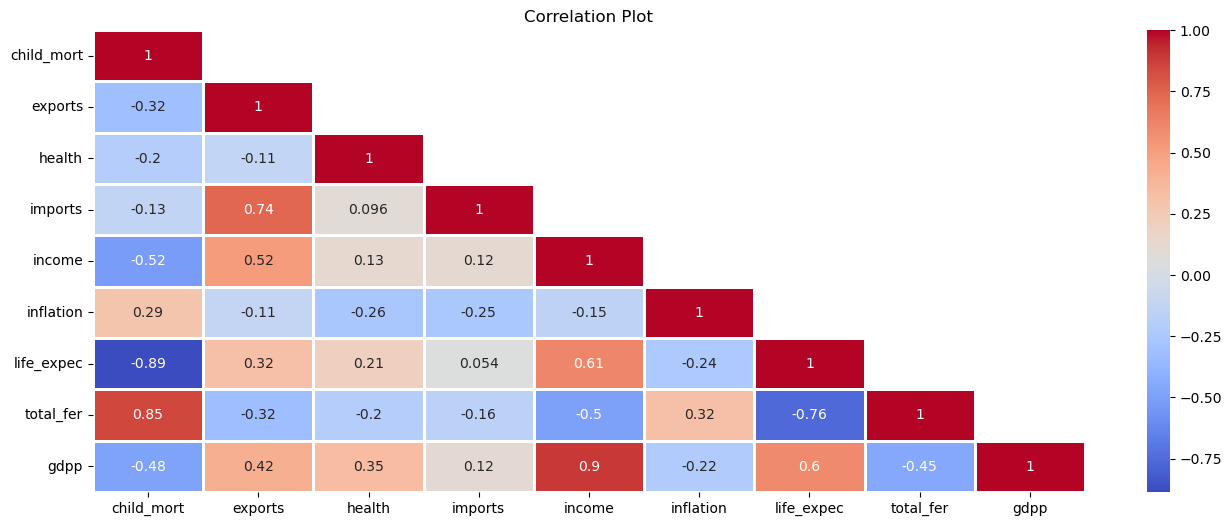

In [6]:
plt.figure(figsize = (16,6))
mask = np.triu(corr_df, k = 1)
sns.heatmap(corr_df, annot = True, linewidths = 1, mask = mask, cmap = 'coolwarm')
plt.title('Correlation Plot')
plt.show()

Notice there is multicolinearity present in our data. Examining some of the correlations, we see:
 - "total_fer" has a high positive correlation with "child_mort" (0.85)
 - "gdpp" has a high positive correlation with "income" (0.9)
 - "life_expec" has a high negative correlation with "child_mort" and "total_fer" (-0.89)


We can visualize these correlations via the following scatterplot matrix.

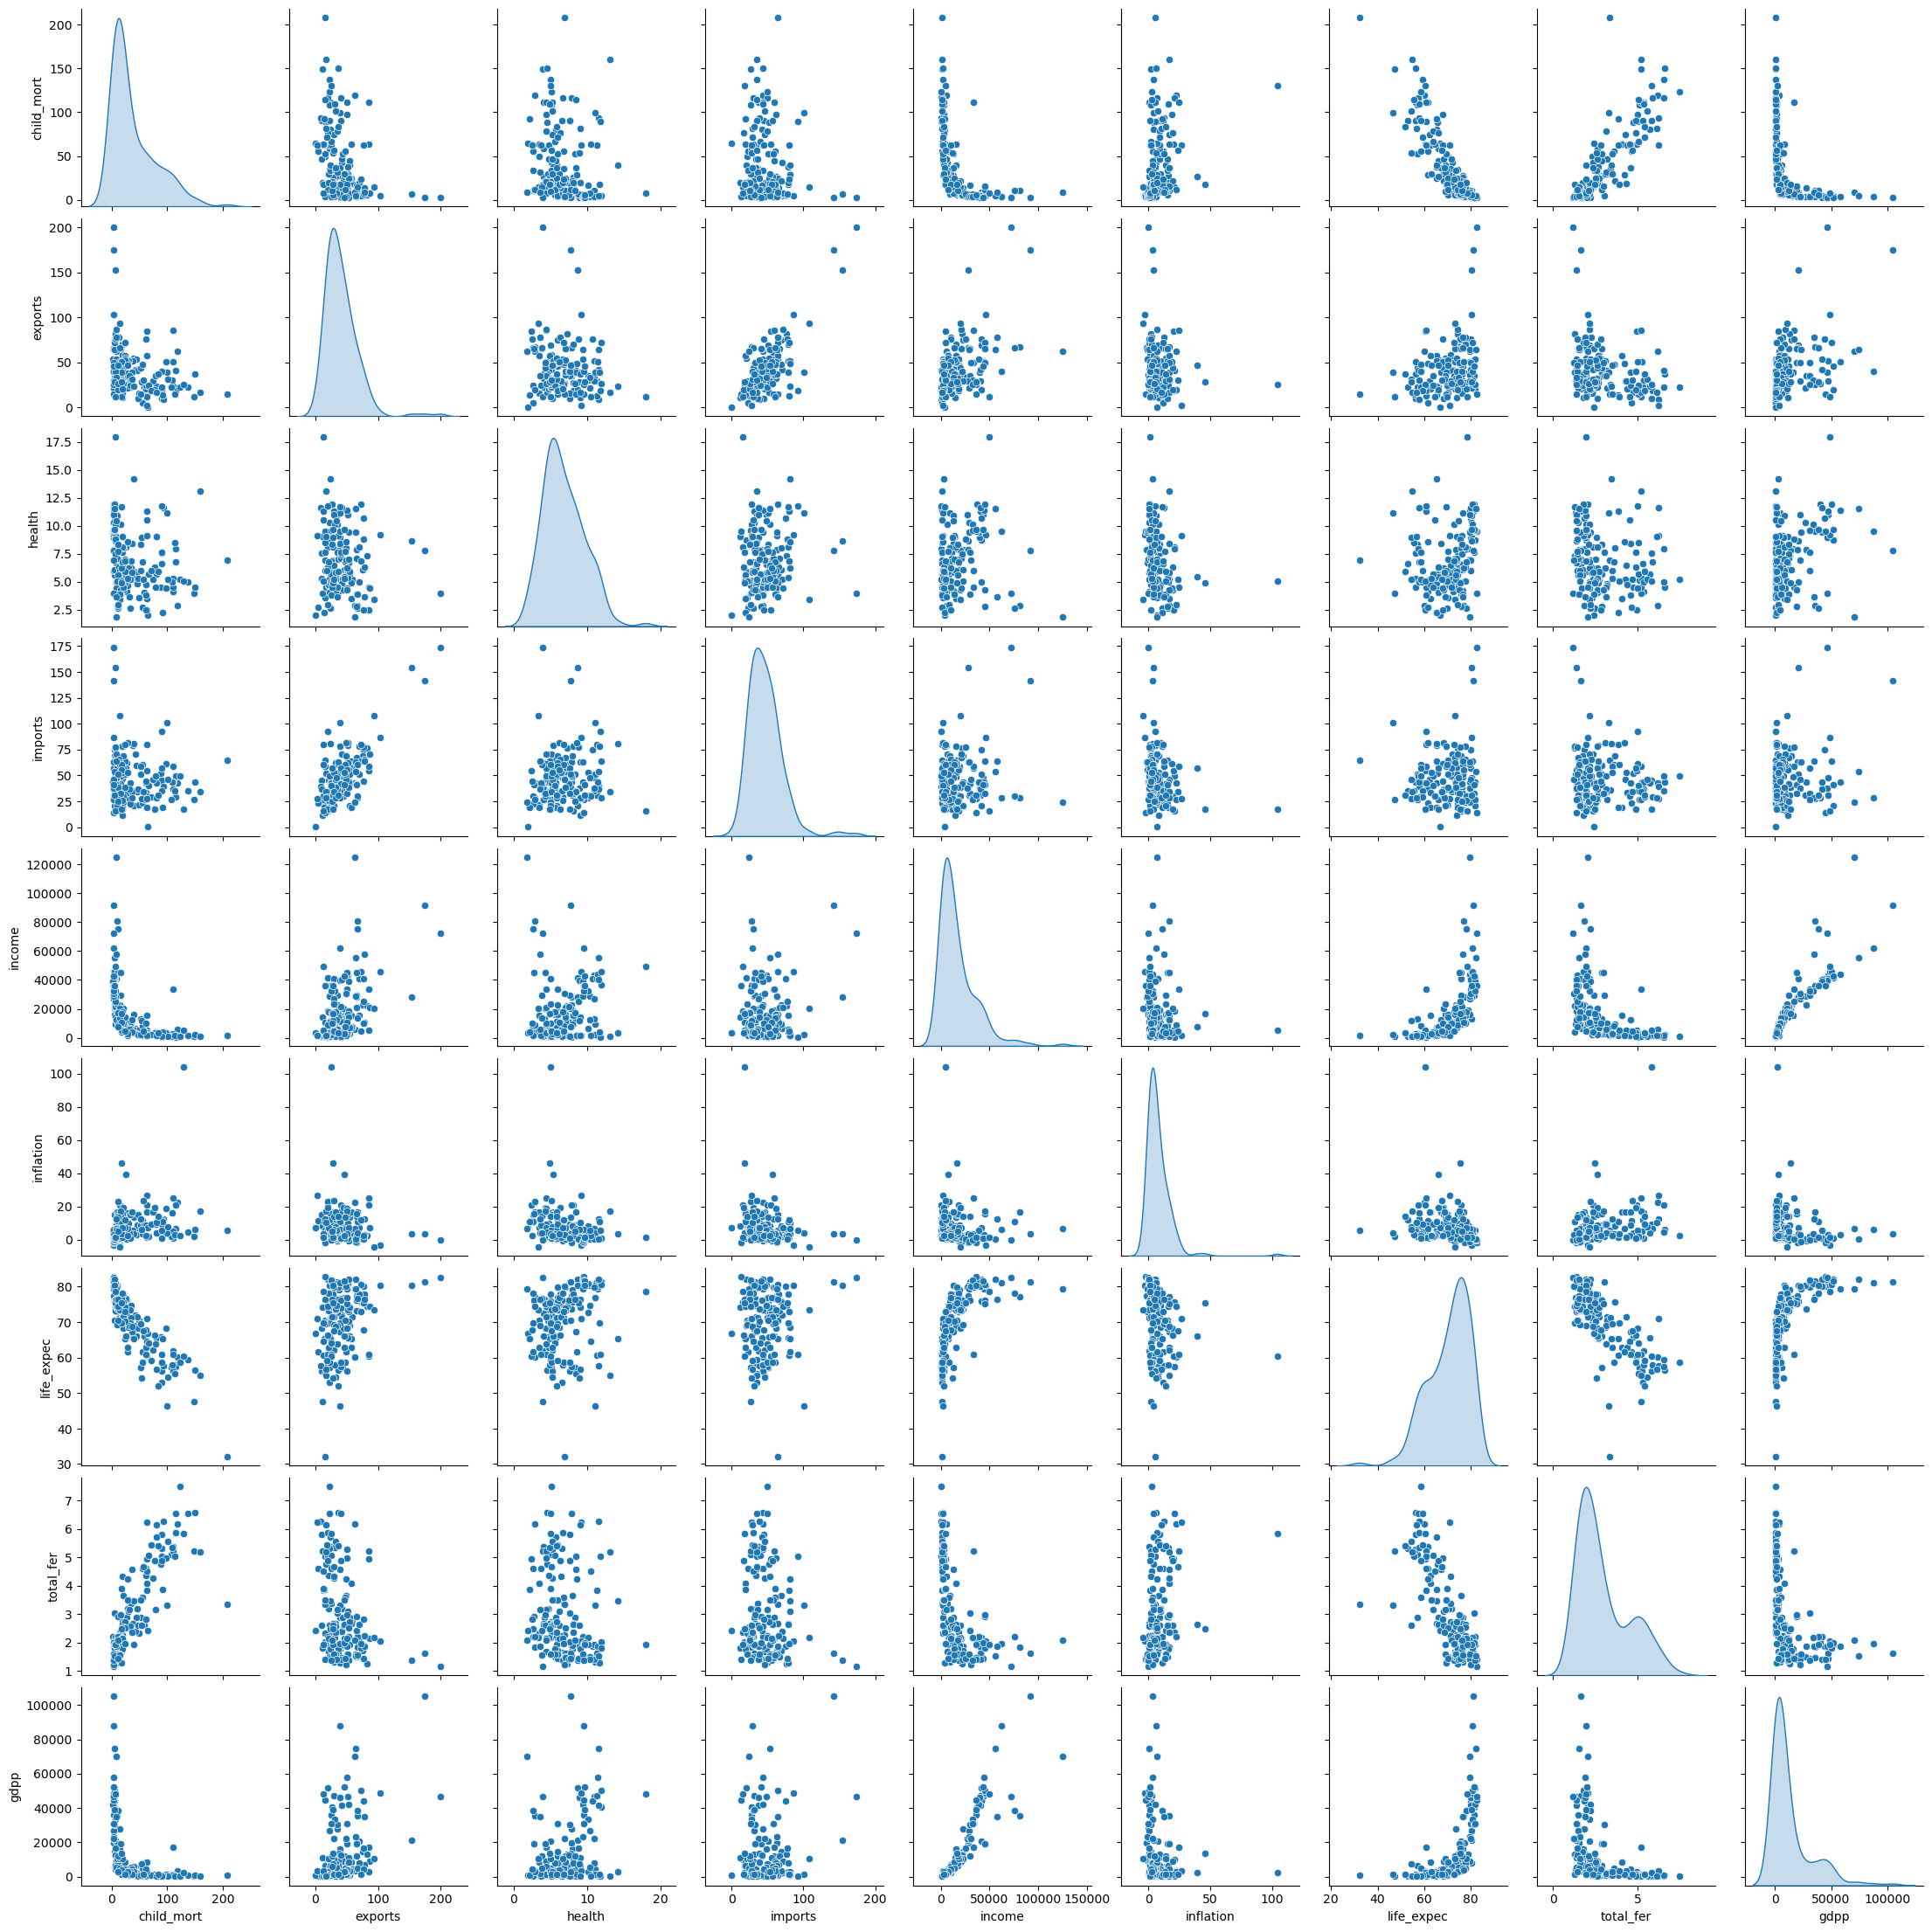

In [7]:
sns.pairplot(Countries, diag_kind = 'kde')
plt.show()

We standardize the data here which is used farther down. 

In [8]:
country = Countries['country']
Countries_num = Countries.drop(columns = ['country'])

In [9]:
sc = StandardScaler()
Xsc = sc.fit_transform(Countries_num)
Countries_scaled = pd.concat([country, pd.DataFrame(Xsc, columns = Countries_num.columns)], axis = 1)

It is always good practice to inspect our data sets.

In [10]:
Countries_scaled.head(n = 10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,Albania,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,Algeria,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,Angola,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,Antigua and Barbuda,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817
5,Argentina,-0.591177,-0.812628,0.468966,-1.279787,0.080920,1.244725,0.591474,-0.382933,-0.145791
6,Armenia,-0.501643,-0.743107,-0.882089,-0.065883,-0.543421,-0.001123,0.309514,-0.833471,-0.533233
7,Australia,-0.832423,-0.779697,0.699011,-1.076779,1.261966,-0.628316,1.290735,-0.674457,2.130699
8,Austria,-0.844858,0.372890,1.527901,0.037693,1.355617,-0.655549,1.121559,-0.999109,1.857082
9,Azerbaijan,0.023128,0.482661,-0.341667,-1.085065,-0.059556,0.571037,-0.164178,-0.681083,-0.389857


### Part 1: Principal Component Analysis for Visualization

This is adapted from Chapter 12, Lab 5 in ISLP (which uses a different data set). We'll perform PCA on the `Countries` dataset and look at some visualizations. Remember, we are not concerned with prediction here (in fact we have no predictor variable!)

The function `PCA()` from the `sklearn.decomposition` package is used to perform the principal component analysis. It is recommended to standardize the variables before performing PCA so we will use the scaled data. 

Note: By default, the `PCA()` transform centers the variables (to have mean 0) but does not scale them.

In [11]:
pca = PCA()
pca_Countries = pca.fit(Countries_scaled.iloc[:, 1:])

We can get the extract the scores after the PCA has been fit.

In [12]:
scores = pca_Countries.transform(Countries_scaled.iloc[:, 1:])
print(scores[1:5])


[[ 0.42991133 -0.58815567 -0.3334855  -1.16105859  0.17467732  0.08457863
   0.24891887 -0.22104247  0.17331578]
 [-0.28522508 -0.45517441  1.22150481 -0.8681145   0.15647465 -0.4016955
  -0.08721359 -0.18416209  0.08403718]
 [-2.93242265  1.69555507  1.52504374  0.83962501 -0.27320893 -0.54799587
  -0.44083464 -0.35599752 -0.09133906]
 [ 1.03357587  0.13665871 -0.22572092 -0.84706269 -0.19300696 -0.20691875
   0.24197789 -0.02368143  0.09426975]]


The loadings can be extracted as well. 

Note: Python calls the loadings, "components".

In [13]:
print(pca_Countries.components_)

[[-0.41951945  0.28389698  0.15083782  0.16148244  0.39844111 -0.19317293
   0.42583938 -0.40372896  0.39264482]
 [ 0.19288394  0.61316349 -0.24308678  0.67182064  0.02253553 -0.00840447
  -0.22270674  0.15523311 -0.0460224 ]
 [-0.02954353  0.14476069 -0.59663237 -0.29992674  0.3015475   0.64251951
   0.11391854  0.01954925  0.12297749]
 [ 0.37065326  0.00309102  0.4618975  -0.07190746  0.39215904  0.15044176
  -0.20379723  0.37830365  0.53199457]
 [-0.16896968  0.05761584  0.51800037  0.25537642 -0.2471496   0.7148691
   0.1082198  -0.13526221 -0.18016662]
 [ 0.20062815 -0.05933283  0.00727646 -0.03003154  0.16034699  0.06628537
  -0.60112652 -0.75068875  0.01677876]
 [-0.07948854 -0.70730269 -0.24983051  0.59218953  0.09556237  0.10463252
   0.01848639  0.02882643  0.24299776]
 [-0.68274306 -0.01419742  0.07249683 -0.02894642  0.35262369 -0.01153775
  -0.50466425  0.29335267 -0.24969636]
 [ 0.3275418  -0.12308207  0.11308797  0.09903717  0.61298247 -0.02523614
   0.29403981 -0.026335

Similarly, here is the proportion of variation explained by each principal component.

In [14]:
print(pca_Countries.explained_variance_ratio_)

[0.4595174  0.17181626 0.13004259 0.11053162 0.07340211 0.02484235
 0.0126043  0.00981282 0.00743056]


And this will give the cumulative variance explained as additional principal components are included.

In [15]:
print(np.cumsum(pca.explained_variance_ratio_))


[0.4595174  0.63133365 0.76137624 0.87190786 0.94530998 0.97015232
 0.98275663 0.99256944 1.        ]


It is easier to visualize these values using plots.

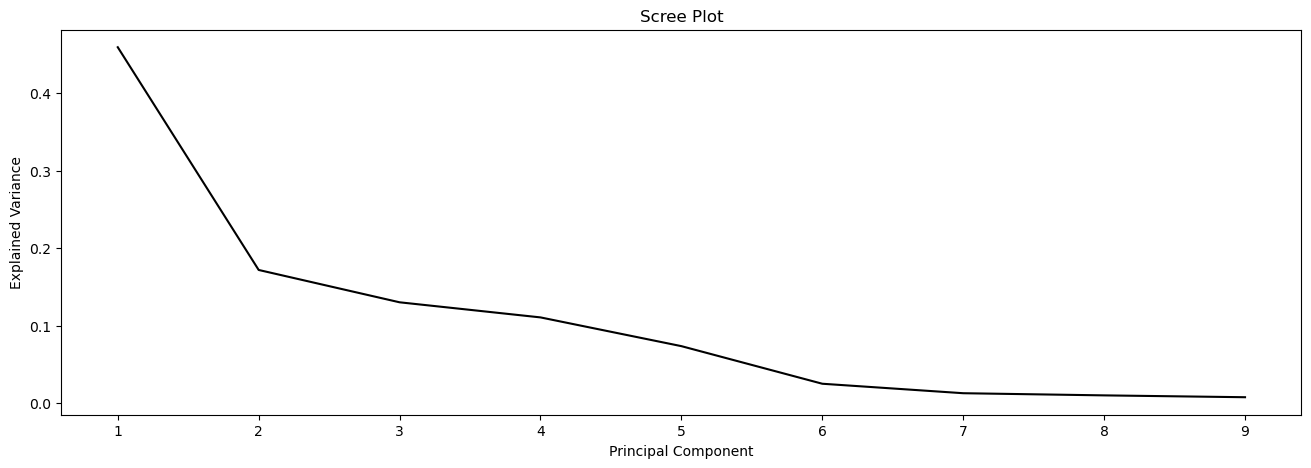

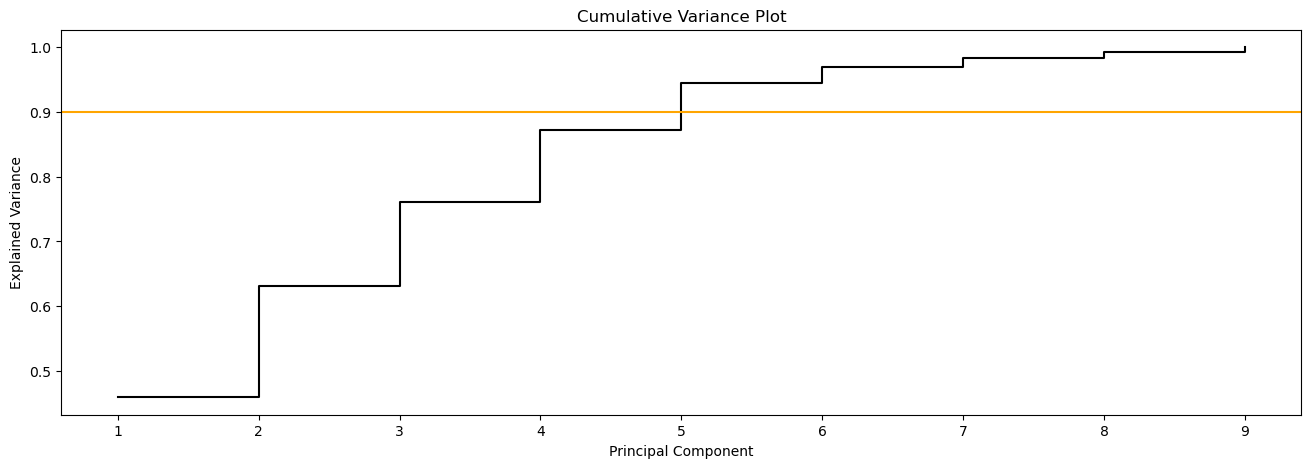

In [16]:
plt.figure(figsize = (16 ,5))
sns.lineplot(x = range(1, 10), y = pca_Countries.explained_variance_ratio_, color = 'black')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

plt.figure(figsize=(16 ,5))
sns.lineplot(x = range(1, 10), y = np.cumsum(pca_Countries.explained_variance_ratio_), 
             drawstyle = 'steps-post', color = "black")
plt.axhline(0.90, color = 'orange')
plt.title('Cumulative Variance Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

<span style="color:orange">If we wanted to find the "optimal" number of PCs, we would use these two plots. It looks like there are both elbows at 2 and 6 components, although that might be two few and too many components respectively. It takes 5 components to retain >90% of the variation in our original data so it would probably be best to consider 5 components.</span>

We can create a biplot to visualize the principal components. Unfortunately, it is not built in as a part of `sklearn`. While there are Python packages to produced biplots, we have produced this biplot manually. Changing the values of `i` and `j` below will plot other pairs of principal components.

Note: We multiply the second principal component by -1 to reflect the graph through the y-axis. This is due to principal components only being unique up to a sign change.

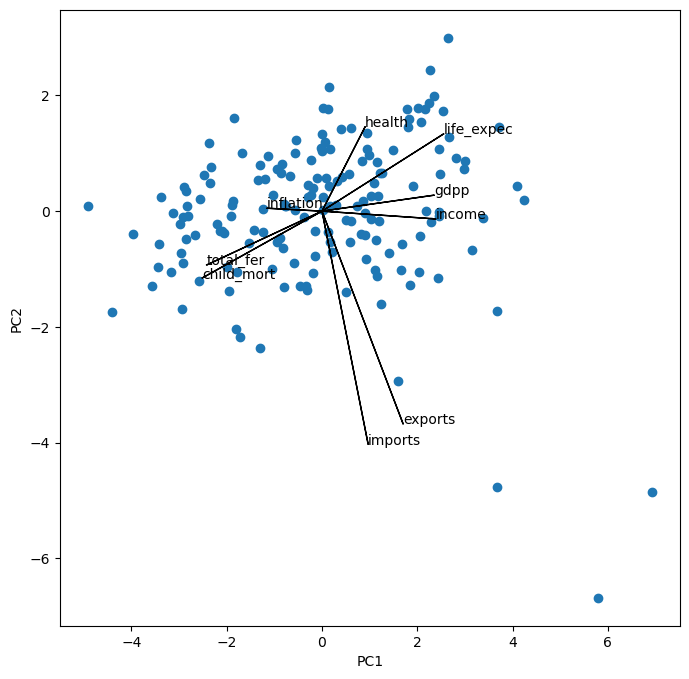

In [17]:
i, j = 0, 1
scale_arrow = s_ = 6
scores[:,1] *= -1
pca_Countries.components_[1] *= -1 # flip the y-axis
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.scatter(scores[:, 0], scores[:, 1])
ax.set_xlabel('PC%d' % (i + 1))
ax.set_ylabel('PC%d' % (j + 1))
for k in range(pca_Countries.components_.shape[1]):
    ax.arrow(0, 0, s_*pca_Countries.components_[i, k], s_*pca_Countries.components_[j, k])
    ax.text(s_*pca_Countries.components_[i, k],
            s_*pca_Countries.components_[j, k],
            Countries.columns[k + 1])

<span style="color:orange">Notice there are some outliers here.</span>

### Part 2: Classifying Countries​ Using Hierarchical Clustering

This exercise is adapted from Chapter 12, Lab 5 in ISLP. We implement hierarchical clustering on the `Countries` data set. We will plot the dendrograms using different linkages. Euclidean distance is used as the disimilarity measure. We will also investigate how standardizing affects the clustering.

The hierarchical clustering will be done using the `AgglomerativeClustering` function. Important parameters include:
- `n_clusters`: The number of clusters to find,
- `metric`: Metric used to compute pairwise disimilarity measure,
- `linkage`: Which linkage criterion to use,
    includes options such as:
    - ward: Minimizes the variance of the clusters being merged,
    - average: Uses the average distances of each observation,
    - complete: Uses the maximum distances between all observations, and
    - single: Uses the minimum distance between all observations,
- `distance_threshold`: The linkage distance threshold at or above which clusters will not be merged, and
- `compute_distances`: Yes/No compute distances even if `distance_threshold` is not used.

Note: One of either `n_cluster` or `distance_threshold` must be given a value (with the other not specified or set to None).

### Full Hierarchical Clustering

First, let's do hierarchical clustering without setting the number of nodes. Setting the distance threshold to zero results in every country being in its own cluster.

In [18]:
HClustFull_Complete = AgglomerativeClustering(linkage = 'complete', n_clusters = None, distance_threshold = 0).fit(Countries.iloc[:, 1:])

The following code prints the countries in each cluster. We see that there are 167 clusters that include only one country each.

In [19]:
for i in range(HClustFull_Complete.n_clusters_):
    print("cluster {} contains countries: \n{}".format(str(i), str(Countries.loc[(HClustFull_Complete.labels_ == i)].iloc[:,0])))

cluster 0 contains countries: 
166    Zambia
Name: country, dtype: object
cluster 1 contains countries: 
165    Yemen
Name: country, dtype: object
cluster 2 contains countries: 
162    Vanuatu
Name: country, dtype: object
cluster 3 contains countries: 
161    Uzbekistan
Name: country, dtype: object
cluster 4 contains countries: 
164    Vietnam
Name: country, dtype: object
cluster 5 contains countries: 
152    Tunisia
Name: country, dtype: object
cluster 6 contains countries: 
143    Suriname
Name: country, dtype: object
cluster 7 contains countries: 
160    Uruguay
Name: country, dtype: object
cluster 8 contains countries: 
159    United States
Name: country, dtype: object
cluster 9 contains countries: 
163    Venezuela
Name: country, dtype: object
cluster 10 contains countries: 
157    United Arab Emirates
Name: country, dtype: object
cluster 11 contains countries: 
147    Tanzania
Name: country, dtype: object
cluster 12 contains countries: 
151    Tonga
Name: country, dtype: object
c

Let's plot the full dendrogram using the `plot_dendrogram()` function we created earlier. The arguments `truncate_mode`, `p`, and `color_threshold` correspond to arguments used in the `dendrogram()` function which is used for plotting. The arguments are as follows:
 - `truncate_mode`: used to condense the dendrogram for large date sets. Setting this to `level` means no more than `p` levels of the dendrogram are displayed
 - `p`: The number of levels of the dendrogram to display
 - `color_threshold`: The vertical point at which clusters below the point are uniquely colored (corresponding to the y-axis)

 Play around with `p` and `color_threshold` and see what happens!

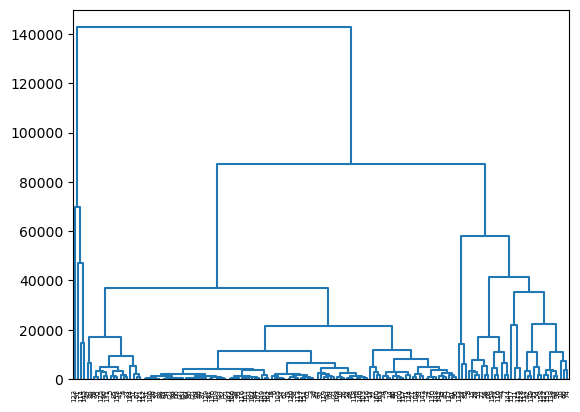

In [20]:
plot_dendrogram(HClustFull_Complete, truncate_mode = 'level', p = 10, color_threshold = 0)

### Hierarchical Clustering for Three Clusters

Now let's make it so we have only three clusters. We can do this in two ways:
1. Cut the tree using `compute_linkage` and `cut_tree`.
2. Rerun the function but specify the `n_clusters` = 3.

In [21]:
linkage_comp = compute_linkage(HClustFull_Complete)
print(cut_tree(linkage_comp, n_clusters = 3).T)

[[0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0
  0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 1 1 0 0 2 1 0 0 0 0 0 0 1 2 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0
  1 2 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0]]


In [22]:
HClustThree_Complete = AgglomerativeClustering(linkage = 'complete', n_clusters = 3, compute_distances = True).fit(Countries.iloc[:,1:])

In [23]:
for i in range(HClustThree_Complete.n_clusters_):
    print("cluster {} contains countries: \n{}".format(str(i), str(Countries.loc[(HClustThree_Complete.labels_ == i)].iloc[:,0])))

cluster 0 contains countries: 
91      Luxembourg
114         Norway
123          Qatar
145    Switzerland
Name: country, dtype: object
cluster 1 contains countries: 
7                 Australia
8                   Austria
10                  Bahamas
11                  Bahrain
15                  Belgium
23                   Brunei
29                   Canada
42                   Cyprus
43           Czech Republic
44                  Denmark
53                  Finland
54                   France
58                  Germany
60                   Greece
68                  Iceland
73                  Ireland
74                   Israel
75                    Italy
77                    Japan
82                   Kuwait
98                    Malta
110             Netherlands
111             New Zealand
115                    Oman
122                Portugal
128            Saudi Arabia
133               Singapore
135                Slovenia
138             South Korea
139                  

Both methods return the same clusters. I prefer refitting the cluster, but that might be computationally wasteful for large datasets.

Note: We had to specify `compute_distances` = True or we would have had an error.

We can also graph the dendrogram with three clusters by changing `color_threshold`.

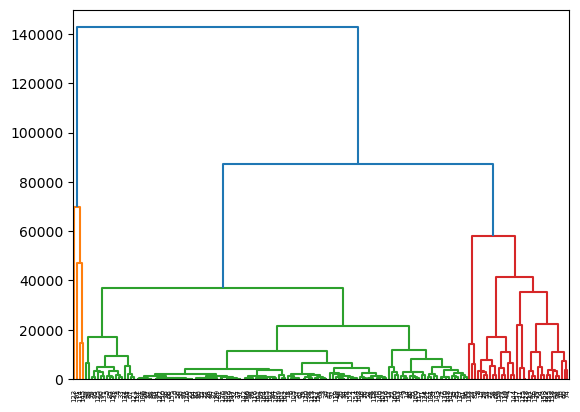

In [24]:
plot_dendrogram(HClustThree_Complete, truncate_mode = 'level', p = 50, color_threshold = 80000)

### Hierarchical Clustering for Three Clusters with Single Linkage

We can also change the linkage which will affect our clustering. Let's try single, but feel free to explore the other linkages as well.

In [25]:
HClustThree_Single = AgglomerativeClustering(linkage = 'single', n_clusters = 3, compute_distances = True).fit(Countries.iloc[:, 1:])

In [26]:
for i in range(HClustThree_Single.n_clusters_):
    print("cluster {} contains countries: \n{}".format(str(i), str(Countries.loc[(HClustThree_Complete.labels_ == i)].iloc[:, 0])))

cluster 0 contains countries: 
91      Luxembourg
114         Norway
123          Qatar
145    Switzerland
Name: country, dtype: object
cluster 1 contains countries: 
7                 Australia
8                   Austria
10                  Bahamas
11                  Bahrain
15                  Belgium
23                   Brunei
29                   Canada
42                   Cyprus
43           Czech Republic
44                  Denmark
53                  Finland
54                   France
58                  Germany
60                   Greece
68                  Iceland
73                  Ireland
74                   Israel
75                    Italy
77                    Japan
82                   Kuwait
98                    Malta
110             Netherlands
111             New Zealand
115                    Oman
122                Portugal
128            Saudi Arabia
133               Singapore
135                Slovenia
138             South Korea
139                  

Here is the full dendrogram which is a fairly difficult to read.

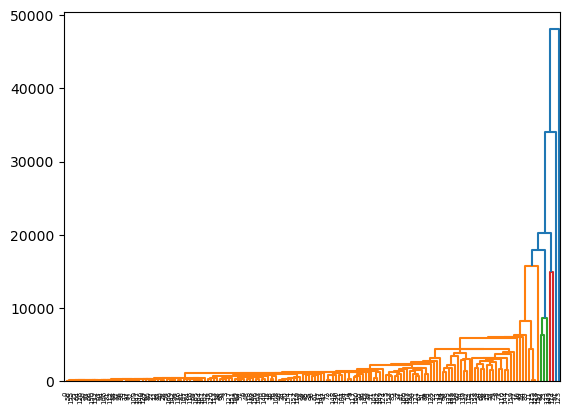

In [27]:
plot_dendrogram(HClustThree_Single, truncate_mode = 'level', p = 50, color_threshold = 17000)

Zooming in a little bit (setting `p` to be smaller) makes it somewhat easier to digest.

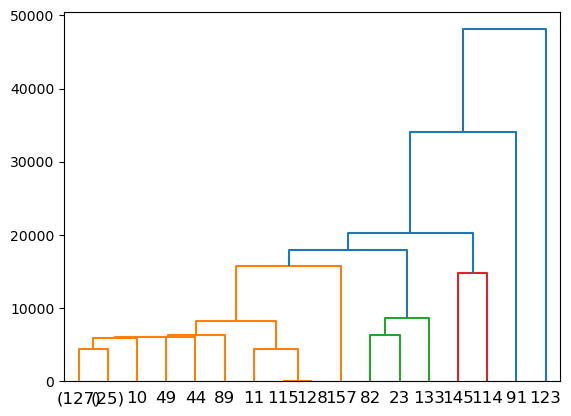

In [28]:
plot_dendrogram(HClustThree_Single, truncate_mode = 'level', p = 10, color_threshold = 17000)

Note: AgglomerativeClustering does something weird and does not consider some points as unique clusters. For example in the dendrogram above, rows 91 and 123 (Luxembourg and Qatar) appear to be their own clusters but are actually included in <span style="color:red">cluster 0</span>. It is unclear why this is.

Play around with other linkages and number of clusters and see what it gives you!

### Hierarchical Clustering the Scaled Data

Now we will cluster with the scaled data to see how that yields different results. We will set `n_clusters` = 3 and plot the dendrogram.

In [29]:
HClustThree_Complete_Scaled = AgglomerativeClustering(linkage = 'complete', n_clusters = 3, compute_distances = True).fit(Countries_scaled.iloc[:, 1:])

In [30]:
for i in range(HClustThree_Complete_Scaled.n_clusters_):
    print("cluster {} contains states: \n{}".format(str(i), str(Countries_scaled.loc[(HClustThree_Complete_Scaled.labels_ == i)].iloc[:, 0])))

cluster 0 contains states: 
0                   Afghanistan
3                        Angola
17                        Benin
18                       Bhutan
21                     Botswana
25                 Burkina Faso
26                      Burundi
27                     Cambodia
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
49            Equatorial Guinea
52                         Fiji
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
65                       Guyana
66                        Haiti
72                         Iraq
80                        Kenya
81                     Kiribati
83              Kyrgyz Republic
84                          Lao
87                      Lesotho
88                      Liberia
93          

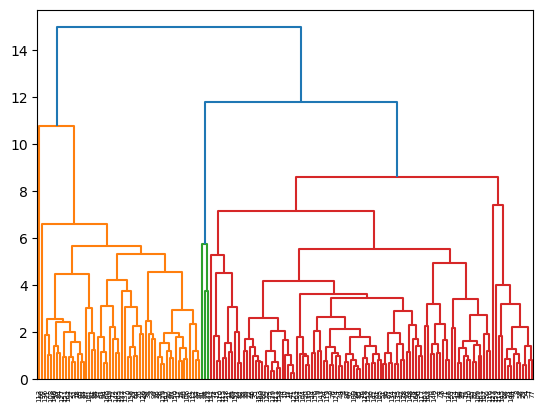

In [31]:
plot_dendrogram(HClustThree_Complete_Scaled, truncate_mode = 'level', p = 50, color_threshold = 11)

### Part 3: Investigating K-means Clustering with PCs

This exercise implements clustering on the `Countries` data set using K-means and principle components. The clustering will be done using the `KMeans()` functions. Remember that in K-means we must specify the number of clusters. We will consider splitting our data into 3 clusters, but you can change this number to see how things change. This will somewhat show the impact that scaling has on clustering as well.

Note: `n_init` is how many times the algorithm is run with different centroid seeds (that is, different random assignment in the first step).

In [32]:
num_clusters = 3

### Unscaled K-means Clustering

First, we will apply K-means clustering using principle components built using the unscaled `Countries` data. We are considering 5 principle components since that is the smallest number that retained >90% of the variation in our original data. The PCA is fit and shown below.

In [33]:
pca = PCA(n_components = 5).fit_transform(Countries.iloc[:, 1:])
pca_Countries = pd.DataFrame(pca, columns=['PC'+ str(i) for i in range(1, pca.shape[1] + 1)])
pca_Countries.head(n = 5)

,PC1,PC2,PC3,PC4,PC5
0,-19815.128018,-1651.124720,38.424930,-0.192311,-13.395274
1,-11338.938992,1493.469028,-28.182163,-14.070214,-7.859092
2,-8926.352589,3264.684102,-11.916113,-16.804181,12.238446
3,-14652.465937,-867.795270,59.558400,40.492538,24.138701
4,896.142032,1898.478151,-29.133957,0.507663,-7.630103


We run k-means and get the labels from the group.

In [34]:
kmeans_unscaled = KMeans(n_clusters = num_clusters, n_init = 20).fit(pca_Countries)
clust_labels_unscaled = list(kmeans_unscaled.labels_)

Here we can visualize the clusters using the first two principle components. It is important to understand that this is a two-dimensional look at the clusters (which are actually 5-dimensional). We see that there is good seperation into the three clusters.

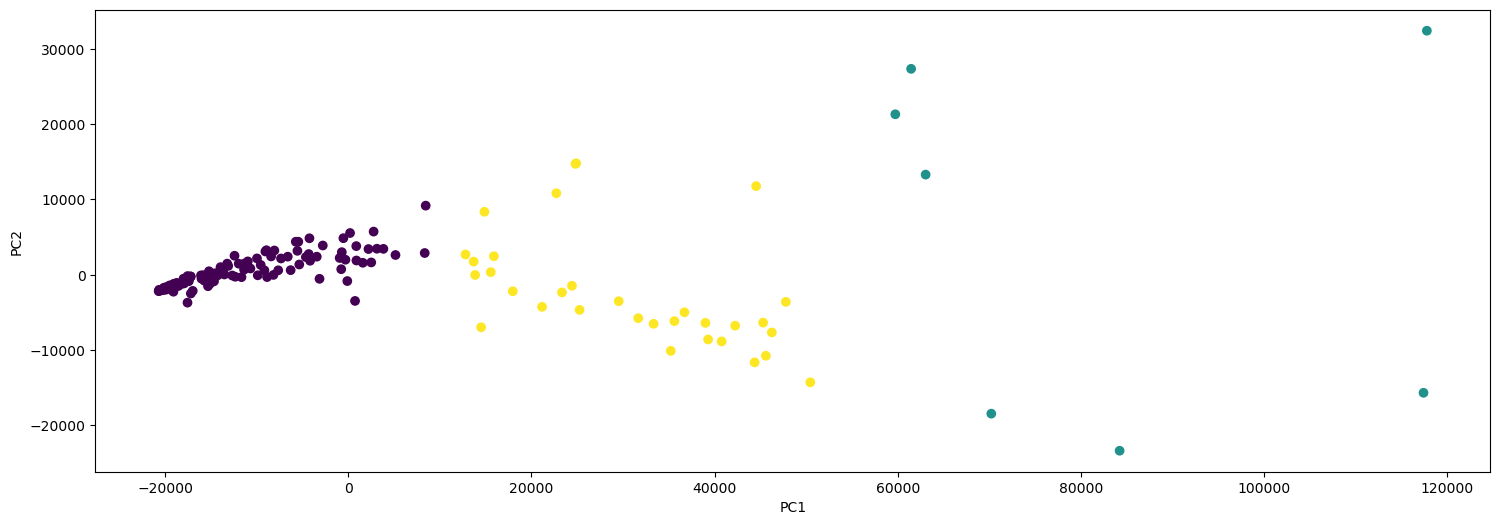

In [35]:
plt.figure(figsize=(18, 6))
plt.scatter(pca_Countries['PC1'], pca_Countries['PC2'], c = clust_labels_unscaled, cmap = 'viridis')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

### Unscaled K-means Clustering

Next, we will apply K-means clustering using principle components built using the scaled `Countries` data. Once again we are considering 5 principle components. The PCA is fit and shown below.

In [36]:
pca = PCA(n_components = 5).fit_transform(Countries_scaled.iloc[:, 1:])
pca_Countries_scaled = pd.DataFrame(pca, columns=['PC'+ str(i) for i in range(1, pca.shape[1] + 1)])
pca_Countries_scaled.head(n = 5)

,PC1,PC2,PC3,PC4,PC5
0,-2.913025,0.095621,-0.718118,1.005255,-0.158310
1,0.429911,-0.588156,-0.333486,-1.161059,0.174677
2,-0.285225,-0.455174,1.221505,-0.868115,0.156475
3,-2.932423,1.695555,1.525044,0.839625,-0.273209
4,1.033576,0.136659,-0.225721,-0.847063,-0.193007


We run k-means and get the labels from the group.

In [37]:
kmeans_scaled = KMeans(n_clusters = num_clusters, n_init = 20).fit(pca_Countries_scaled)
clust_labels_scaled = list(kmeans_scaled.labels_)

Again we visualize the clusters using the first two principle components. We see that the clusters are very different from the unscaled clusters. While this may seem worse than the in the unscaled case above, we still see very good separation in the clusters (it is also only one way to "look down" on the five dimensions). 

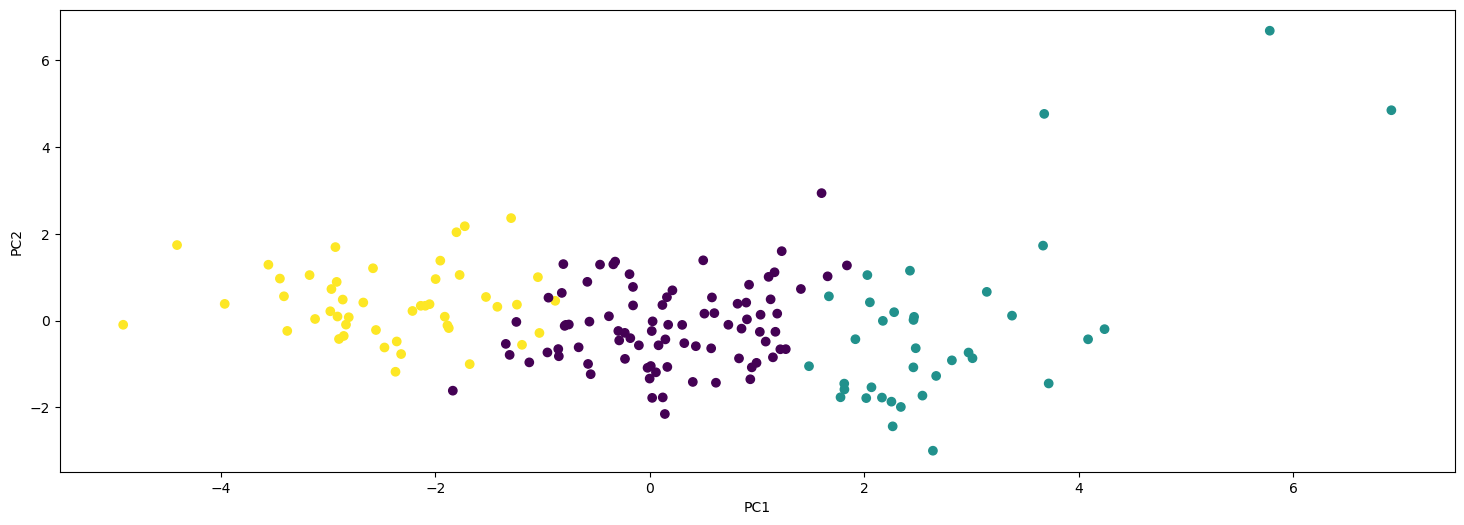

In [38]:
plt.figure(figsize = (18, 6))
plt.scatter(pca_Countries_scaled['PC1'], pca_Countries_scaled['PC2'], c = clust_labels_scaled, cmap = 'viridis')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

Lets inspect our clusters a little more in depth. We will start with counts and grouped averages of the original variables.

In [39]:
Countries['labels'] = clust_labels_scaled
Countries['labels'].value_counts()

labels
0    84
2    47
1    36
Name: count, dtype: int64

In [40]:
Countries.iloc[:, 1:].groupby('labels').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
labels,,,,,,,,,
0,21.927381,40.243917,6.200952,47.473404,12305.595238,7.600905,72.814286,2.307500,6486.452381
1,5.000000,58.738889,8.807778,51.491667,45672.222222,2.671250,80.127778,1.752778,42494.444444
2,92.961702,29.151277,6.388511,42.323404,3942.404255,12.019681,59.187234,5.008085,1922.382979


It looks like we have pretty good separation here as the means are all fairly different. If we inspect the clusters we infer what these clusters might be. We see that there the clusters are:
 - Countries with very high GDP, exports, imports, income, health, and life expectancy and very low child mortality, inflation, and total fertility. 
 - Countries with low GDP, exports, imports, income, health, and life expectancy and high child mortality, inflation, and total fertility.
 - Countries that fall in between the other two groups.
 
We can describe these clusters as developed, least developed, and developing countries respectively.

Here we inspect the countries in each cluster.

In [41]:
country_groups = Countries.groupby('labels')['country']
print(country_groups.get_group(0).unique(), "\n")
print(country_groups.get_group(1).unique(), "\n")
print(country_groups.get_group(2).unique())

['Albania' 'Algeria' 'Antigua and Barbuda' 'Argentina' 'Armenia'
 'Azerbaijan' 'Bahamas' 'Bangladesh' 'Barbados' 'Belarus' 'Belize'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Bulgaria'
 'Cambodia' 'Cape Verde' 'Chile' 'China' 'Colombia' 'Costa Rica' 'Croatia'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Estonia' 'Fiji'
 'Georgia' 'Grenada' 'Guatemala' 'Guyana' 'Hungary' 'India' 'Indonesia'
 'Iran' 'Jamaica' 'Jordan' 'Kazakhstan' 'Kyrgyz Republic' 'Latvia'
 'Lebanon' 'Libya' 'Lithuania' 'Macedonia, FYR' 'Malaysia' 'Maldives'
 'Mauritius' 'Micronesia, Fed. Sts.' 'Moldova' 'Mongolia' 'Montenegro'
 'Morocco' 'Myanmar' 'Nepal' 'Oman' 'Panama' 'Paraguay' 'Peru'
 'Philippines' 'Poland' 'Romania' 'Russia' 'Samoa' 'Saudi Arabia' 'Serbia'
 'Seychelles' 'Solomon Islands' 'Sri Lanka'
 'St. Vincent and the Grenadines' 'Suriname' 'Tajikistan' 'Thailand'
 'Tonga' 'Tunisia' 'Turkey' 'Turkmenistan' 'Ukraine' 'Uruguay'
 'Uzbekistan' 'Vanuatu' 'Venezuela' 'Vietnam'] 

['Australia' '

## Part 4: Does Clustering Really Work?
This exercise will look at the performance of clustering methods on data that is actually clustered. Both unscaled K-means and scaled K-means will be fit. Remember that clustering is **unsupervised**. In practice we don't know the true cluster labels but, we will use the true cluster labels here to show that the methods actually work.

We will consider the `OliveOil` data set which contains 572 observations corresponding to olive oils from 9 different regions of Italy. The variables include Area.name (the label) which is the region the olive oil is from and eight measurements on fatty acid contained in the oils. The goal is to cluster the oils into regions based on the fatty acid measurements.

The following code loads the `OliveOil` data set from a csv file. 

In [42]:
OliveOil = pd.read_csv('OliveOils.csv', header = 0)

The nine different regions are shown below.

In [43]:
regions = OliveOil['Area.name'].unique()
print(regions)

['North-Apulia' 'Calabria' 'South-Apulia' 'Sicily' 'Inland-Sardinia'
 'Coastal-Sardinia' 'Umbria' 'East-Liguria' 'West-Liguria']


Here we inspect the first few rows of the data set. 

In [44]:
OliveOil.head(n = 10)

,Area.name,palmitic,palmitoleic,strearic,oleic,linoleic,eicosanoic,linolenic
0,North-Apulia,1075,75,226,7823,672,36,60
1,North-Apulia,1088,73,224,7709,781,31,61
2,North-Apulia,911,54,246,8113,549,31,63
3,North-Apulia,966,57,240,7952,619,50,78
4,North-Apulia,1051,67,259,7771,672,50,80
5,North-Apulia,911,49,268,7924,678,51,70
6,North-Apulia,922,66,264,7990,618,49,56
7,North-Apulia,1100,61,235,7728,734,39,64
8,North-Apulia,1082,60,239,7745,709,46,83
9,North-Apulia,1037,55,213,7944,633,26,52


We standardize the data and inspect the first few rows once again

In [45]:
region_values =  OliveOil['Area.name']
OliveOil_num = OliveOil.drop(columns = ['Area.name'])
sc = StandardScaler()
Xsc = sc.fit_transform(OliveOil_num)
OliveOil_scaled = pd.concat([region_values, pd.DataFrame(Xsc, columns = OliveOil_num.columns)], axis = 1)
OliveOil_scaled.head(n = 10)

,Area.name,palmitic,palmitoleic,strearic,oleic,linoleic,eicosanoic,linolenic
0,North-Apulia,-0.930520,-0.974183,-0.078049,1.260932,-1.271825,0.317340,0.086416
1,North-Apulia,-0.853343,-1.012316,-0.132526,0.979767,-0.822501,-0.068541,0.131848
2,North-Apulia,-1.904132,-1.374576,0.466720,1.976178,-1.778859,-0.068541,0.222711
3,North-Apulia,-1.577616,-1.317377,0.303290,1.579093,-1.490303,1.397807,0.904189
4,North-Apulia,-1.073000,-1.126714,0.820820,1.132681,-1.271825,1.397807,0.995053
5,North-Apulia,-1.904132,-1.469908,1.065966,1.510035,-1.247091,1.474984,0.540734
6,North-Apulia,-1.838829,-1.145780,0.957013,1.672815,-1.494425,1.320631,-0.095312
7,North-Apulia,-0.782103,-1.241112,0.167097,1.026628,-1.016246,0.548869,0.268143
8,North-Apulia,-0.888963,-1.260178,0.276051,1.068556,-1.119302,1.089102,1.131349
9,North-Apulia,-1.156113,-1.355510,-0.432149,1.559362,-1.432592,-0.454422,-0.277039


### Unscaled K-means Clustering

First, we will apply K-means clustering to the original (unscaled) `OliveOil` data. Remember, in kmeans we have to specify how many clusters we want. Specifying the number of clusters is not trivial in most cases. We do not touch on methods for determining the number of clusters in this course. For example, there are certain metrics that can be used.

In [46]:
kmeans_unscaled = KMeans(n_clusters = 9, n_init = 20).fit(OliveOil.iloc[:, 1:])
clust_labels_unscaled = kmeans_unscaled.labels_.tolist()
for i in range(0, len(clust_labels_unscaled)):
    for j in range(9):
        if (clust_labels_unscaled[i] == j):
            clust_labels_unscaled[i] = regions[j]
    

Label switching is a big issue here as Python has no idea that "North-Apulia" is the first group in the data set which means "North-Apulia" might not be the first cluster. The following code remedies this by re-labeling the predicted labels.

Note: This is not a great fix as we **should not** apply classification evaluation measures to clustering.

In [47]:
conf_mat = confusion_table(OliveOil['Area.name'], clust_labels_unscaled)
cluster_labels_str = pd.Series(clust_labels_unscaled).astype(str)
row_ind, col_ind = linear_sum_assignment(-conf_mat)
cluster_to_true_label = {
    str(conf_mat.columns[col]): conf_mat.index[row]
    for row, col in zip(row_ind, col_ind)
}
predicted_labels_unscaled = cluster_labels_str.map(cluster_to_true_label)


Here we can look at a confusion matrix and the accuracy of our clustering.

In [48]:
confusion_table(OliveOil['Area.name'], predicted_labels_unscaled)

Truth,Calabria,Coastal-Sardinia,East-Liguria,Inland-Sardinia,North-Apulia,Sicily,South-Apulia,Umbria,West-Liguria
Predicted,,,,,,,,,
Calabria,48,0,5,0,0,3,0,0,0
Coastal-Sardinia,0,33,0,0,0,0,0,0,0
East-Liguria,2,0,32,0,0,0,0,16,0
Inland-Sardinia,0,0,0,65,0,0,0,0,0
North-Apulia,1,0,9,0,0,0,0,13,2
Sicily,11,0,7,1,1,7,2,2,5
South-Apulia,5,16,0,3,31,77,74,0,0
Umbria,0,0,0,0,0,0,0,51,0
West-Liguria,1,0,5,3,0,0,0,2,39


In [49]:
cnt = 0
for i in range(9):
    cnt += confusion_matrix(OliveOil['Area.name'], predicted_labels_unscaled)[i][i]
print("Accuracy rate: " + str(round(cnt/len(OliveOil), 3)))

Accuracy rate: 0.61


### Scaled K-means Clustering

Next, we apply K-means clustering to the scaled `OliveOil` data.

In [50]:
kmeans_scaled = KMeans(n_clusters = 9, n_init = 20).fit(OliveOil_scaled.iloc[:, 1:])
clust_labels_scaled = kmeans_scaled.labels_.tolist()
for i in range(0, len(clust_labels_scaled)):
    for j in range(9):
        if (clust_labels_scaled[i] == j):
            clust_labels_scaled[i] = regions[j]

We once again fix the labels.

In [51]:
conf_mat = confusion_table(OliveOil['Area.name'], clust_labels_scaled)
cluster_labels_str = pd.Series(clust_labels_scaled).astype(str)
row_ind, col_ind = linear_sum_assignment(-conf_mat)
cluster_to_true_label = {
    str(conf_mat.columns[col]): conf_mat.index[row]
    for row, col in zip(row_ind, col_ind)
}
predicted_labels_scaled = cluster_labels_str.map(cluster_to_true_label)

Here we can look at a confusion matrix and the accuracy of our clustering with scaled data.

In [52]:
confusion_table(OliveOil['Area.name'], predicted_labels_scaled)

Truth,Calabria,Coastal-Sardinia,East-Liguria,Inland-Sardinia,North-Apulia,Sicily,South-Apulia,Umbria,West-Liguria
Predicted,,,,,,,,,
Calabria,30,0,3,0,0,23,0,0,0
Coastal-Sardinia,0,0,0,33,0,0,0,0,0
East-Liguria,0,0,31,0,0,1,0,7,11
Inland-Sardinia,0,0,0,65,0,0,0,0,0
North-Apulia,1,0,22,0,0,0,0,2,0
Sicily,15,2,6,0,0,12,1,0,0
South-Apulia,14,47,0,2,0,1,142,0,0
Umbria,0,0,3,0,0,0,0,48,0
West-Liguria,0,0,0,0,15,0,0,0,35


In [53]:
cnt = 0
for i in range(9):
    cnt += confusion_matrix(OliveOil['Area.name'], predicted_labels_scaled)[i][i]
print("Accuracy rate: " + str(round(cnt/len(OliveOil), 3)))

Accuracy rate: 0.635


We see that scaling the data slightly improved our accuracy. This does an alright job of categorizing the oils but does not do amazingly well as many of the oils are fairly similar to each other. With that being said, if you were asked to cluster these oils into nine groups and you did it randomly, you would probably have close to a 0.111 (1/9) accuracy rate which is much worse than what we got in both the scaled and unscaled cases.